In [1]:
from functions.ca_model import *
from functions.read_data import *
from functions.analyze import *
import zipfile
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
ROWS = COLS = 101
GENERATIONS = 500

In [3]:
history_csv_file = '../data/history_data.csv'
history_array = []
history_array = read_history(history_array, history_csv_file)

"""
Time-step matrices are stored in a zip. 
To unzip, uncomment the following lines of code.
"""
# # define file path and folder to extract in
# matrix_zip_path = '../data/matrices_data.zip'
# extraction_folder = '../data/'

# with zipfile.ZipFile(matrix_zip_path, 'r') as zip_ref:
#     # Extract all the contents into the target directory
#     zip_ref.extractall(extraction_folder)

matrices_csv_file = '../data/matrices_data.csv'
all_M = read_matrix(ROWS, COLS, GENERATIONS, matrices_csv_file)

Importing completed, there are 100 history entries in total


'\nTime-step matrices are stored in a zip. \nTo unzip, uncomment the following lines of code.\n'

## 1. Time to Metastasis vs K1 and K2

In [4]:
K1_values = np.arange(0.2, 0.9, (0.9-0.2)/50)
K2_values = np.arange(0.2, 0.4, (0.4-0.2)/50)

In [5]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

pickle_file_path = '../data/generation_above_50cluster_k2s.pkl'

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

time_array = np.array(data)
time_array = np.array([[float(entry) if entry is not None else np.nan for entry in row] for row in time_array])

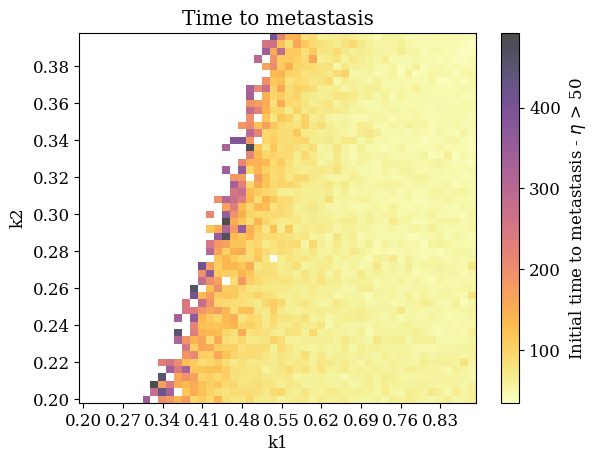

In [24]:
fig, ax = plt.subplots()
im = ax.imshow(time_array, cmap='inferno_r', interpolation='none', aspect='auto', origin='lower', alpha=0.7)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'Initial time to metastasis - $\eta$ > 50')

ax.set_xlabel('k1')
ax.set_ylabel('k2')
ax.set_xticks(np.arange(len(K1_values)))
ax.set_yticks(np.arange(len(K2_values)))
ax.set_xticklabels([f'{k:.2f}' for k in K1_values])
ax.set_yticklabels([f'{k:.2f}' for k in K2_values])

# Ensure that every tick label is displayed
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax.set_title('Time to metastasis')

plt.show()


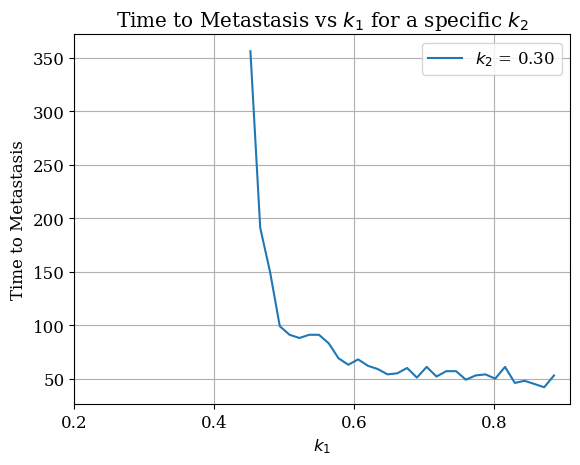

In [15]:
"""
Select the row for a specific k2 value
Let's say we want to plot the line for k2 = 0.3
Find the index in K2_values that is closest to 0.3
"""
k2_index = (np.abs(K2_values - 0.3)).argmin()
selected_time_values = time_array[k2_index]

fig, ax = plt.subplots()
ax.plot(K1_values, selected_time_values, label=r'$k_2$ = 'f'{K2_values[k2_index]:.2f}')
ax.set_xlabel(r'$k_1$')
ax.set_ylabel('Time to Metastasis')
ax.grid(True)
ax.legend()
ax.set_xticks(np.arange(0.2, 0.9, 0.05))

# Ensure that every tick label is displayed and avoid overlap
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=6, steps=[1, 2, 5, 10]))
ax.set_title(r'Time to Metastasis vs $k_1$ for a specific $k_2$')

plt.show()


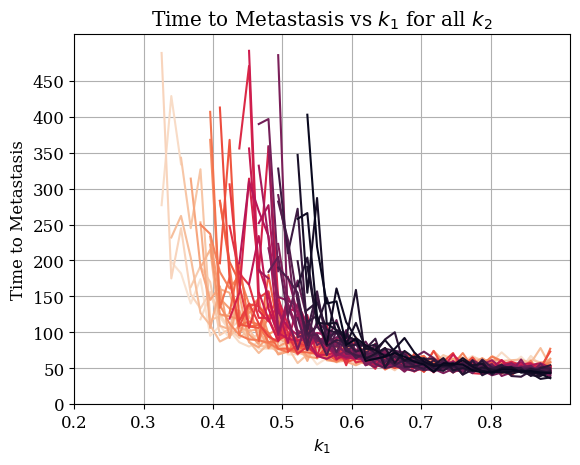

In [14]:
fig, ax = plt.subplots()

gradient_palette = sns.color_palette('rocket_r',len(K2_values))

# Plot lines for each k2 value
for k2_index, k2_value in enumerate(K2_values):
    selected_time_values = time_array[k2_index]
    ax.plot(K1_values, selected_time_values, color=gradient_palette[k2_index], label=f'k2 = {k2_value:.2f}')

ax.set_xlabel(r'$k_1$')
ax.set_ylabel('Time to Metastasis')
ax.set_xticks(np.arange(0.2, 0.9, 0.1))
ax.set_yticks(np.arange(0,500,50))
ax.set_title(r'Time to Metastasis vs $k_1$ for all $k_2$')
ax.grid(True) # grid for better readability

plt.show()


## 2. Finite Size Scaling

In [6]:
"""
This cell takes longer than 30 mins to run.
A shorter simulation can be run by taking the following ranges for parameters:
system size:    range(100,301,100)
k1:             np.arange(0,1,0.2)
"""

# Now call this function inside your loop
clusters = {}
time_to_metastasis = {}

# Loop over each system size and K1
for system_size in range(100, 501, 100):
    rows = cols = system_size  # Assuming a square grid
    clusters[system_size] = {}
    time_to_metastasis[system_size] = {}
    
    for K1 in np.arange(0, 1, 0.1):
        cluster_at_each_gen, Tm = simulate_and_find_metastasis(400, system_size, system_size, K1, 0.3)
        clusters[system_size][K1] = cluster_at_each_gen
        time_to_metastasis[system_size][K1] = Tm
            
        print ("Size:", system_size, "k1 :", K1, "done")
        

Size: 100 k1 : 0.0 done
Size: 100 k1 : 0.1 done
Size: 100 k1 : 0.2 done
Size: 100 k1 : 0.30000000000000004 done
Size: 100 k1 : 0.4 done
Size: 100 k1 : 0.5 done
Size: 100 k1 : 0.6000000000000001 done
Size: 100 k1 : 0.7000000000000001 done
Size: 100 k1 : 0.8 done
Size: 100 k1 : 0.9 done
Size: 200 k1 : 0.0 done
Size: 200 k1 : 0.1 done
Size: 200 k1 : 0.2 done
Size: 200 k1 : 0.30000000000000004 done
Size: 200 k1 : 0.4 done
Size: 200 k1 : 0.5 done
Size: 200 k1 : 0.6000000000000001 done
Size: 200 k1 : 0.7000000000000001 done
Size: 200 k1 : 0.8 done
Size: 200 k1 : 0.9 done
Size: 300 k1 : 0.0 done
Size: 300 k1 : 0.1 done
Size: 300 k1 : 0.2 done
Size: 300 k1 : 0.30000000000000004 done
Size: 300 k1 : 0.4 done
Size: 300 k1 : 0.5 done
Size: 300 k1 : 0.6000000000000001 done
Size: 300 k1 : 0.7000000000000001 done
Size: 300 k1 : 0.8 done
Size: 300 k1 : 0.9 done
Size: 400 k1 : 0.0 done
Size: 400 k1 : 0.1 done
Size: 400 k1 : 0.2 done
Size: 400 k1 : 0.30000000000000004 done
Size: 400 k1 : 0.4 done
Size: 

KeyboardInterrupt: 

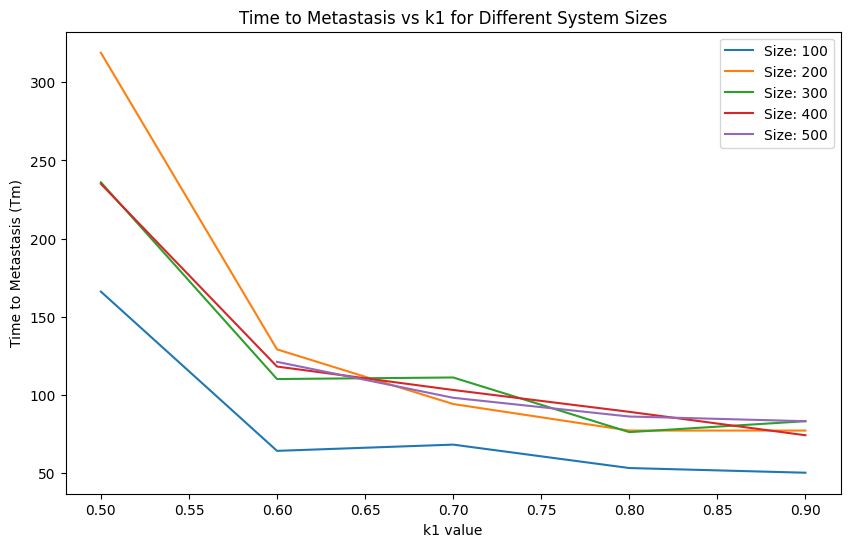

In [9]:
plt.figure(figsize=(10, 6))

# Plotting each system size
for system_size in time_to_metastasis:
    # Extracting k1 values and corresponding Tm for this system size
    k1_values = list(time_to_metastasis[system_size].keys())
    Tm_values = list(time_to_metastasis[system_size].values())

    # Plotting the line for this system size
    plt.plot(k1_values, Tm_values, label=f'Size: {system_size}')

plt.xlabel('k1 value')
plt.ylabel('Time to Metastasis (Tm)')
plt.title('Time to Metastasis vs k1 for Different System Sizes')
plt.legend()
plt.show()

In [5]:
# Saving a dictionary as JSON
with open('data/time_to_metastasis.json', 'w') as f:
    json.dump(time_to_metastasis, f)

with open('data/clusters.json', 'w') as f:
    json.dump(clusters, f)

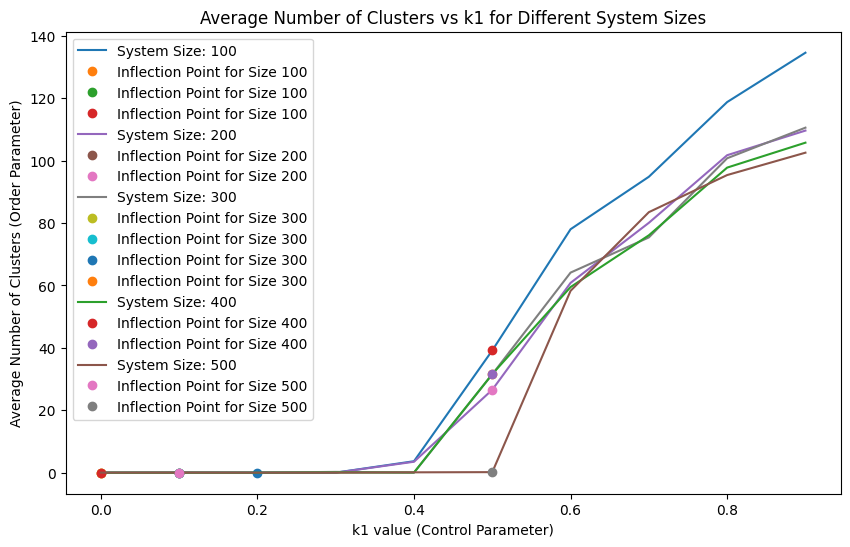

In [7]:
# Helper function to compute the second derivative using a central finite difference method
def second_derivative(y, x):
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    return d2y

# Prepare the plot
plt.figure(figsize=(10, 6))

# Loop through each system size
for system_size, k1_dict in clusters.items():
    k1_values = np.array(sorted(k1_dict.keys()))
    mean_cluster_counts = np.array([np.mean(k1_dict[k1]) for k1 in k1_values])

    # Calculate second derivative of cluster counts
    sec_deriv_cluster_counts = second_derivative(mean_cluster_counts, k1_values)

    # Plot the mean cluster count for each k1 value
    plt.plot(k1_values, mean_cluster_counts, label=f'System Size: {system_size}')

    # Find indices where the second derivative changes sign (zero-crossings)
    zero_crossings = np.where(np.diff(np.sign(sec_deriv_cluster_counts)))[0]
    
    # Plot the zero-crossing points
    for zc in zero_crossings:
        # Ensure we don't go out of index bounds due to differentiation
        if zc < len(k1_values) - 1:
            plt.plot(k1_values[zc], mean_cluster_counts[zc], 'o', label=f'Inflection Point for Size {system_size}')

# Add axis labels and a title
plt.xlabel('k1 value (Control Parameter)')
plt.ylabel('Average Number of Clusters (Order Parameter)')
plt.title('Average Number of Clusters vs k1 for Different System Sizes')
plt.legend()

# Show the plot
plt.show()
